In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/testimages/smollimgtest/smolimg2-bicubic.png
/kaggle/input/testimages/smollimgtest/smolimg1-fsrgan.png
/kaggle/input/testimages/smollimgtest/smolimg1-bilinear.png
/kaggle/input/testimages/smollimgtest/ogimg1.png
/kaggle/input/testimages/smollimgtest/smolimg2-bilinear.png
/kaggle/input/testimages/smollimgtest/ogimg2.png
/kaggle/input/testimages/smollimgtest/smolimg2-lanczos.png
/kaggle/input/testimages/smollimgtest/smolimg2-fsrgan.png
/kaggle/input/testimages/smollimgtest/smolimg1-lanczos.png
/kaggle/input/tesimages320/DJI_00061.png
/kaggle/input/tesimages320/DJI_0010.JPG
/kaggle/input/tesimages320/test_edited_320.png
/kaggle/input/tesimages320/DJI_0001.JPG
/kaggle/input/tesimages320/DJI_0004.JPG
/kaggle/input/tesimages320/DJI_0002.JPG
/kaggle/input/tesimages320/DJI_0007.JPG
/kaggle/input/tesimages320/DJI_0003.JPG
/kaggle/input/tesimages320/test_edited_320.jpg
/kaggle/input/tesimages320/DJI_0011.JPG
/kaggle/input/tesimages320/0001.png
/kaggle/input/tesimages320/ooooo.png
/

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
x_train_dir = '/kaggle/input/uavid-images-320/uavid_images_320/uavid_train/ResizedImages'
y_train_dir = '/kaggle/input/uavid-images-320/uavid_images_320/uavid_train/ResizedLabels'

x_valid_dir = '/kaggle/input/uavid-images-320/uavid_images_320/uavid_val/ResizedImages'
y_valid_dir = '/kaggle/input/uavid-images-320/uavid_images_320/uavid_val/ResizedLabels'

x_test_dir = '/kaggle/input/uavid-images-320/uavid_images_320/uavid_val/ResizedImages'
y_test_dir = '/kaggle/input/uavid-images-320/uavid_images_320/uavid_val/ResizedLabels'

In [4]:
img = cv2.imread('/kaggle/input/testtest/LR test/image/seq107.png')
print(img.shape)

(320, 320, 3)


In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i == n:
            plt.imshow(image)
        plt.imshow(image, cmap='gray')
            
    plt.show()

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [7]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['safe','notsafe']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        _, mask = cv2.threshold(mask, 60, 255, cv2.THRESH_BINARY)
#         mask = ~mask
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

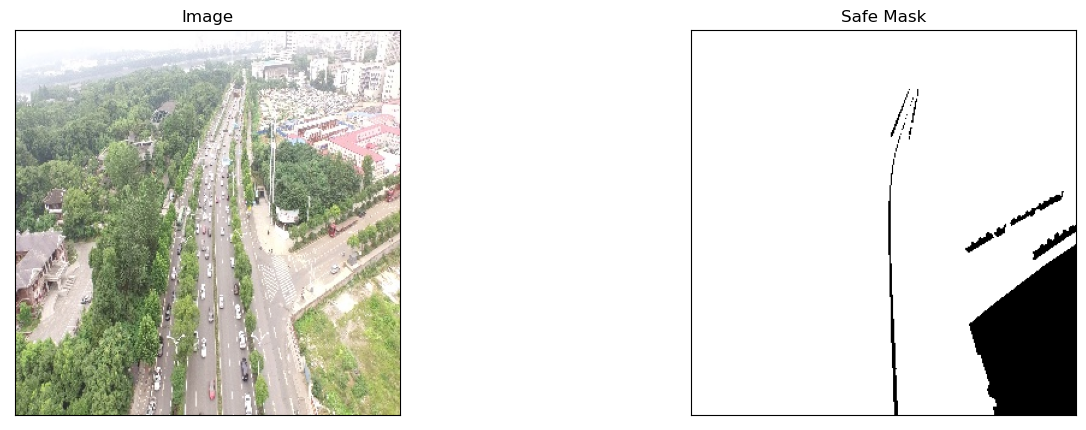

In [8]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['safe'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    safe_mask=mask.squeeze(),
)

In [9]:
import albumentations as albu


In [10]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(320, 320)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1151: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albument

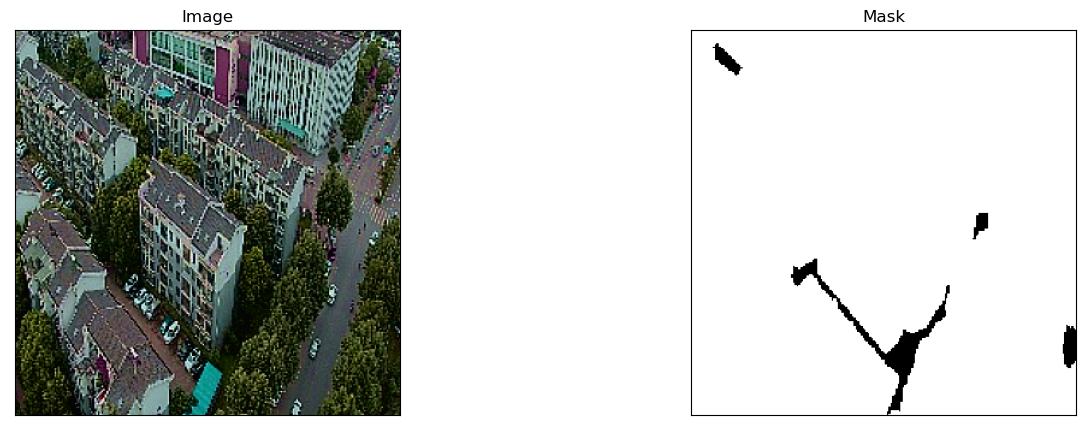

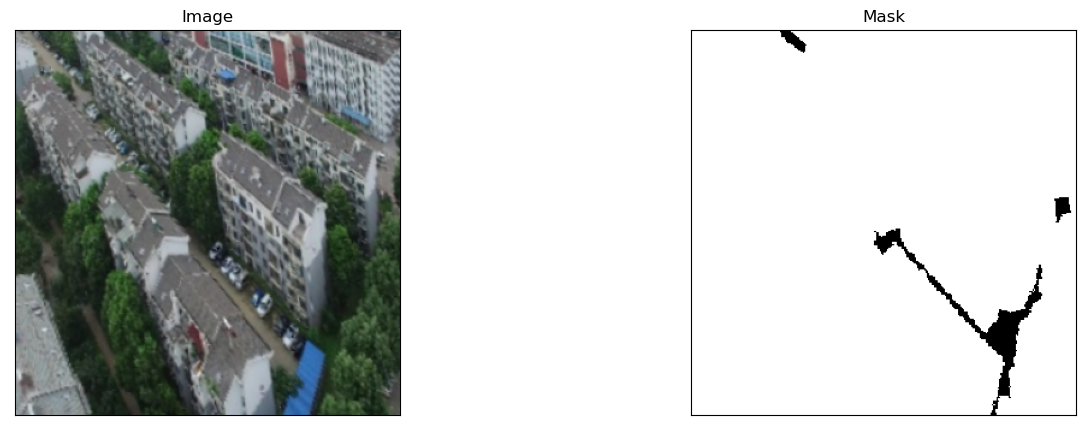

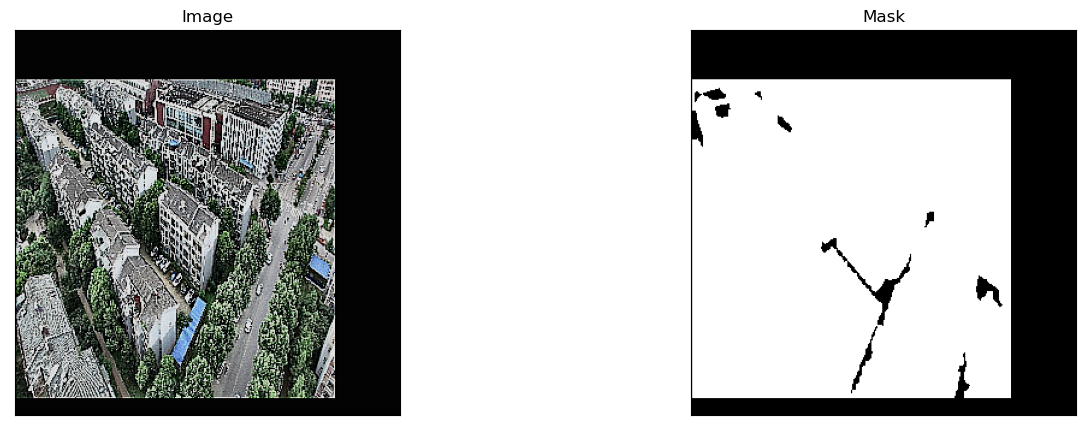

In [11]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['safe'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

In [12]:


!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch



  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-t_e698l_
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-t_e698l_
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit e5d3db20e9c2ddb76f88642409e527239943c983
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.5 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.3-py3-none-any.whl size=106725 sha256=28d10b1836529c1d9e92764777db5caada56b510cea2b0dded4be79570af4400

In [13]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [14]:

import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [15]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['safe']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


  0%|          | 0.00/105M [00:00<?, ?B/s]

In [16]:
# summary(model, input_size=(3, 320, 320))

In [17]:
# print(model)

In [18]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1151: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albument

In [19]:

import segmentation_models_pytorch.utils.metrics
from sklearn.metrics import roc_auc_score, f1_score
import torch.nn as nn


In [20]:

loss = smp.utils.losses.DiceLoss()
# loss = nn.CrossEntropyLoss()
# loss = self.loss.__name__
metrics = [
    smp.utils.metrics.IoU(threshold=0.5, ),
    smp.utils.metrics.Accuracy(threshold=0.5),
    smp.utils.metrics.Precision()
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [21]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [22]:
max_score = 0

for i in range(0, 19):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
#     print()
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 70/70 [00:03<00:00, 21.54it/s, dice_loss - 0.1678, iou_score - 0.8745, accuracy - 0.8857, precision - 0.8849]
Model saved!

Epoch: 1
valid: 100%|██████████| 70/70 [00:03<00:00, 20.15it/s, dice_loss - 0.1273, iou_score - 0.893, accuracy - 0.9097, precision - 0.916]  
Model saved!

Epoch: 2
valid: 100%|██████████| 70/70 [00:03<00:00, 18.36it/s, dice_loss - 0.1042, iou_score - 0.8836, accuracy - 0.8942, precision - 0.8872] 

Epoch: 3
valid: 100%|██████████| 70/70 [00:03<00:00, 21.62it/s, dice_loss - 0.09345, iou_score - 0.9009, accuracy - 0.915, precision - 0.9102] 
Model saved!

Epoch: 4
valid: 100%|██████████| 70/70 [00:03<00:00, 21.61it/s, dice_loss - 0.08655, iou_score - 0.8875, accuracy - 0.899, precision - 0.8913] 

Epoch: 5
valid: 100%|██████████| 70/70 [00:03<00:00, 19.43it/s, dice_loss - 0.08847, iou_score - 0.9032, accuracy - 0.9213, precision - 0.9366]
Model saved!

Epoch: 6
valid: 100%|██████████| 70/70 [00:03<00:00, 21.16it/s, dice_loss - 0.0

In [23]:
best_model = torch.load('./best_model.pth')


In [24]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [25]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 70/70 [00:03<00:00, 20.23it/s, dice_loss - 0.05326, iou_score - 0.9184, accuracy - 0.9332, precision - 0.9379]


In [26]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

In [27]:
# mkdir images

In [28]:
# cd images

In [29]:
# rm -r *

In [30]:
# mkdir Image

In [31]:
# mkdir ground_truth

In [32]:
# mkdir prediction

In [33]:
# !zip -r all.zip /kaggle/working/images

(320, 320)


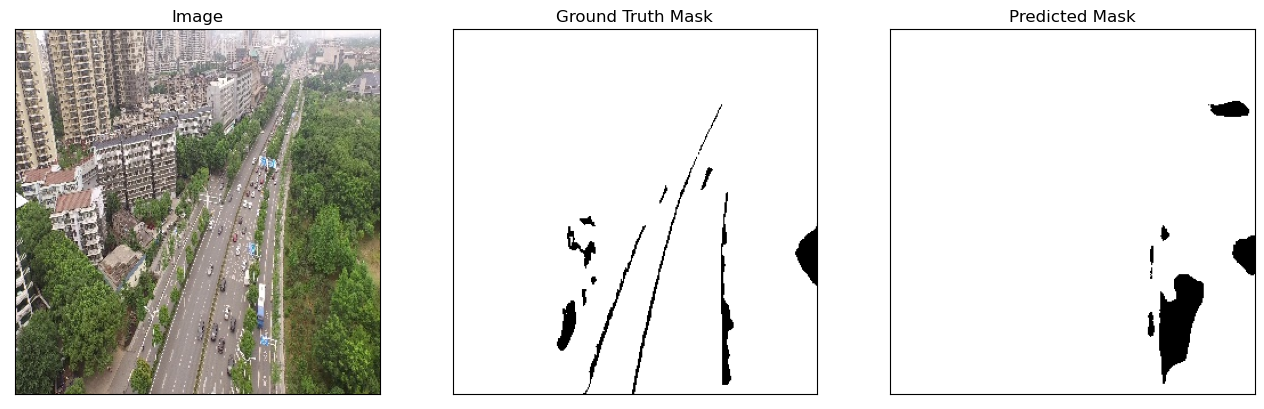

(320, 320)


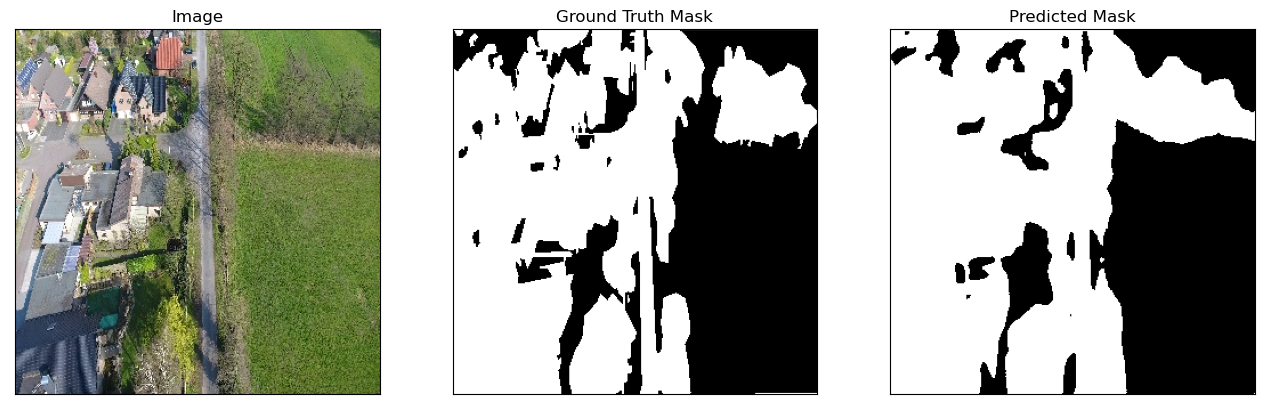

(320, 320)


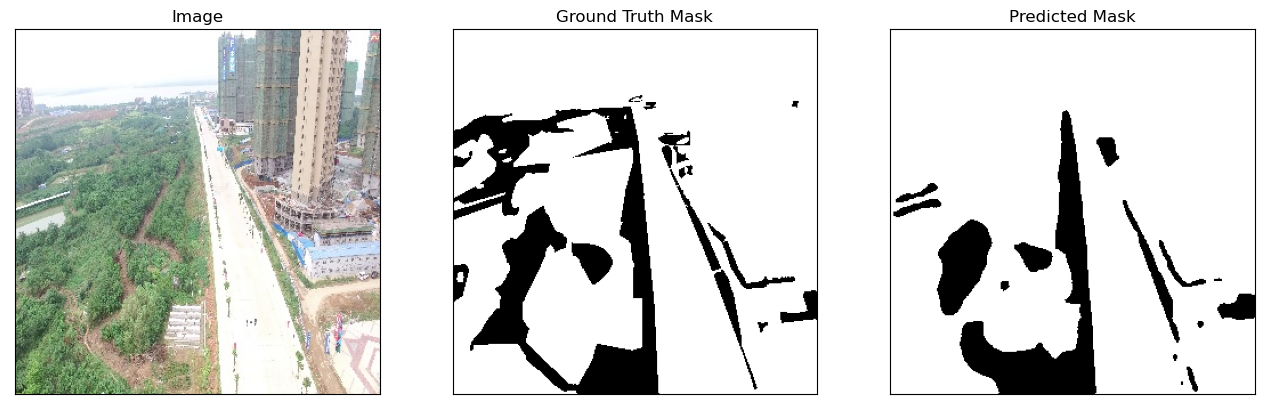

(320, 320)


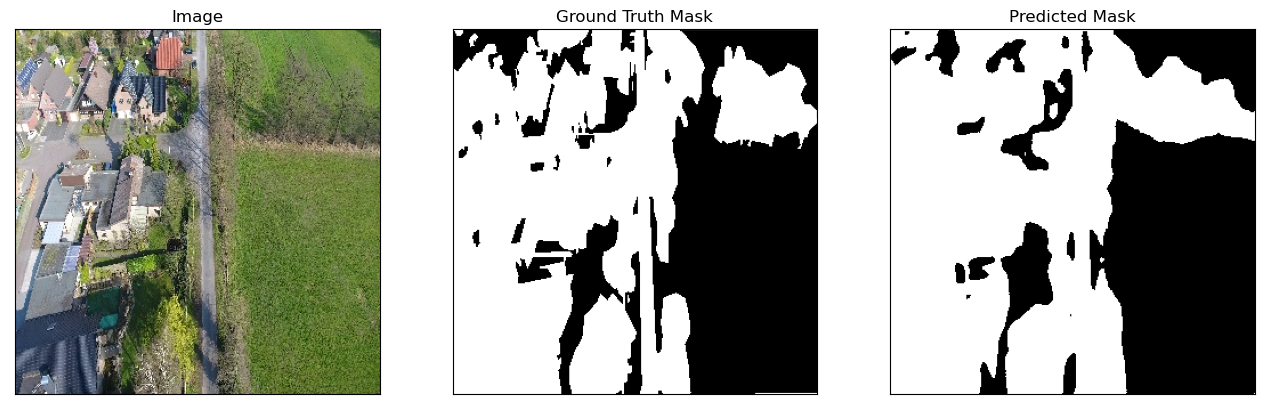

(320, 320)


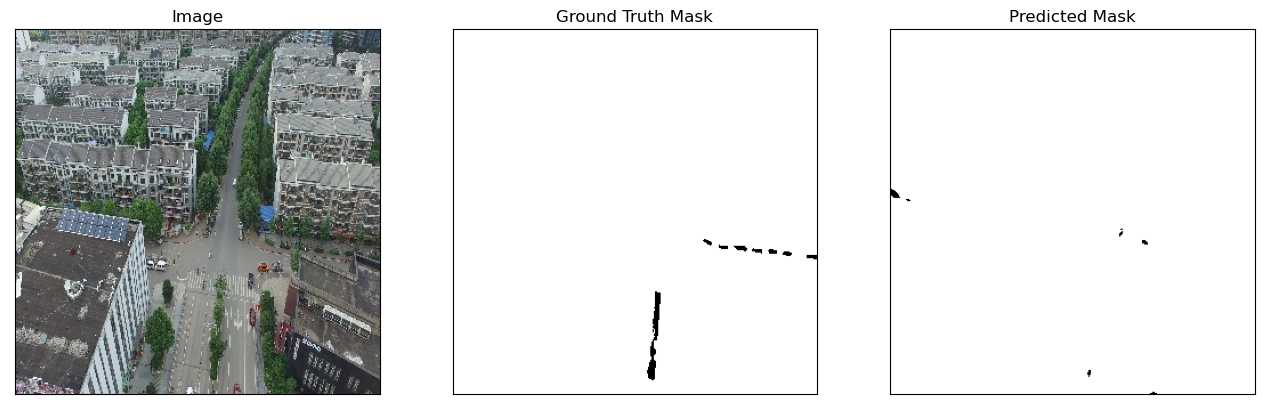

In [34]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    img = cv2.cvtColor(image_vis, cv2.COLOR_BGR2RGB)
#     cv2.imwrite('/kaggle/working/images/Image/%i.jpg' %i, image_vis)
    
    gt_mask = gt_mask.squeeze()
    gt_image = gt_mask.astype(np.uint8)
    gt_image = gt_image*255
    gt_image = cv2.bitwise_not(gt_image)
#     gt_image = np.swapaxes(gt_image, 0,2)
#     gt_image = np.swapaxes(gt_image, 0,1)
    print(gt_image.shape)
#     cv2.imwrite('/kaggle/working/images/ground_truth/%i.jpg' %i, gt_image)
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    pr_image = pr_mask.astype(np.uint8)
    pr_image = pr_image*255
    pr_image = cv2.bitwise_not(pr_image)
#     pr_image = np.swapaxes(pr_image, 0,2)
#     pr_image = np.swapaxes(pr_image, 0,1)
#     cv2.imwrite('/kaggle/working/images/prediction/%i.jpg' %i, pr_image)
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [35]:
def compute_f1_score(y_true, y_pred):
    # Flatten the predictions and ground truth
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Compute the F1 score
    f1 = f1_score(y_true, y_pred)

    return f1

def compute_auc_roc_score(y_True, y_predicted):
    y_True = y_True.flatten()
    y_predicted = y_predicted.flatten()
    
    auc_roc_score = roc_auc_score(y_True, y_predicted)
    
    return auc_roc_score

In [36]:
print(compute_f1_score(gt_mask, pr_mask))
print(compute_auc_roc_score(gt_mask, pr_mask))

0.9971346424180679
0.5236859626130638


In [37]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

Number of trainable parameters: 50988609


In [38]:
# test custom image

In [39]:
def visualize_and_save(**images):
    """PLot images in one row."""
    n = len(images)
#     plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
#         plt.subplot(1, n, i + 1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.title(' '.join(name.split('_')).title())
#         if i == 0:
#             plt.imshow(image)
        if i != 0:
            plt.imshow(image, cmap='gray')
#             plt.savefig('/kaggle/working/testoutput/ogimg1.png')
            image = image.astype(np.uint8)
            print(image)
            image = image*255
            image = cv2.bitwise_not(image)
            print(image.shape)
            cv2.imwrite('/kaggle/working/seq317.png', image)
    plt.show()

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [1 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
(320, 320)


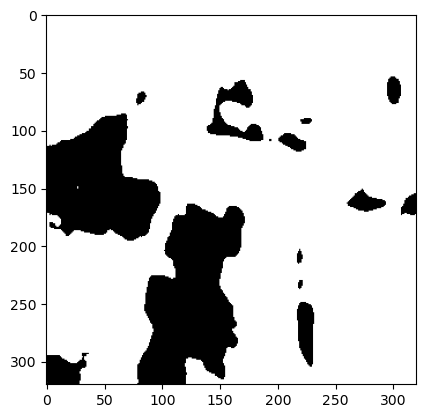

In [40]:
def image_loader(image_name):
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image_pre = preprocessing_fn(image)
    image_vis = image.astype('uint8')
    x_tensor = torch.from_numpy(image_pre.transpose(2,0,1).astype('float32')).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    return image, pr_mask
image, pr_mask = image_loader('/kaggle/input/testtest/LR test/image/seq317.png')
visualize_and_save(image=image, predicted=pr_mask)

In [45]:
#  !zip  weight.zip /kaggle/working/best_model.pth

  adding: kaggle/working/best_model.pth (deflated 8%)


In [42]:
# rm -r testoutput


In [47]:
# rm weight.zip

In [44]:
# mkdir testoutput